### Table Of Contents:

    Section 0: Initializing our notebook
        0.0: Statement
        0.1: Importing Packages

    Section 1: Data Preprocessing & Visualization
        1.0: Loading Data
        1.1: Preprocessing Data pt. 1
        1.2: Data Visualization of Numerical variables
        1.3: Data Visualization of Categorical variables
        1.4: Preprocessing Data pt. 2

    Section 2: Dimensionality reduction and Data analysis
        2.0: Correlation Analysis
        2.1: Random Forest Analysis
        2.2: Dimensionality Reduction

    Section 3: Classification
        3.0: Functions for Classification
        3.1: LogisticRegression
        3.2: SVCs
        3.3: Decision Tree

    Section 4: Ensemble Learning
        4.0: Random Forests
        4.1: Voting classifier
        4.2: Bagging Classifier
        4.3: Gradient Boosting
        4.4: Stacking Classifiers
    
    Section 5: Ensemble Learning with Neural Net
        5.0: Preprocessing for Ensemble Neural Net
        5.1: Stacking with custom Neural Network
        5.2: Scoring for Neural Net

    Section 6: Interpretting Model Results
        6.0: Model Analysis
        
    Section 7: Fin
        7.0 Conclusion

### 0.0: Statement

In this project, we will analyze how different variables can affect the salary of an individual, and to reduce the feature set accordingly. We will then build Binary classifiers of increasing levels of complexity, ending with classifiers inputing into a custom Neural Net. The main goals are to: create an understanding of the circumstances in one's life that will correlate with a higher probability for him or her, of receiving a greater than $50,000 annual salary, and to analyze how various models perform in terms of precision, recall, accuracy, F1 score, ROC, and the AUC score.

### 0.1 Importing Packages
We will be importing the following. I will turn off FutureWarnings to make the notebook cleaner

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, recall_score, roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier 
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## 1.0 Loading Data
I download the data from Kaggle:

https://www.kaggle.com/lodetomasi1995/income-classification

Limited information about the data can be found there

In [2]:
df=pd.read_csv('income_evaluation.csv')
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


## 1.1 Preprocessing Data pt.1

In [3]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

As you can tell, many columns start with a space. Let's rename the columns by splitting the names with a space

In [4]:
[df.rename(columns={col: col.split(' ')[-1]}, inplace=True) for col in df.columns]
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Next, we create a boolean target set (' >50K':True, ' <=50K':False)

In [5]:
y_train=df['income']
y_train=y_train==' >50K'
X_train=df.drop(['income'], axis=1)

We will use k-fold cross validation for most classifiers, but will leave a hold-out test set nonetheless

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=.15, random_state=41)
#Let's reset the index for every set:
[set_df.reset_index(drop=True, inplace=True) for set_df in [X_train, X_test, y_train, y_test]]

[None, None, None, None]

Let's take a look at whether or not we have to deal with missing data:

In [7]:
X_train.isnull().sum().sum()

0

Apparently not! Let's check to see what kinds of objects we will be dealing with:

In [8]:
X_train.info(verbose=True, null_counts=True) #Test set has no nulls as well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27676 entries, 0 to 27675
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27676 non-null  int64 
 1   workclass       27676 non-null  object
 2   fnlwgt          27676 non-null  int64 
 3   education       27676 non-null  object
 4   education-num   27676 non-null  int64 
 5   marital-status  27676 non-null  object
 6   occupation      27676 non-null  object
 7   relationship    27676 non-null  object
 8   race            27676 non-null  object
 9   sex             27676 non-null  object
 10  capital-gain    27676 non-null  int64 
 11  capital-loss    27676 non-null  int64 
 12  hours-per-week  27676 non-null  int64 
 13  native-country  27676 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.0+ MB


It's a mixture between strings and numbers, so we will have to do more data processing

In [9]:
X_train.iloc[:3,:]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,59,?,160662,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,2407,0,60,United-States
1,50,Private,209320,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States
2,47,Local-gov,228372,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,48,United-States


In [10]:
y_train[:3]

0    False
1     True
2     True
Name: income, dtype: bool

## 1.2: Data Visualization Numerical variables
Before we encode our categorical variables, let's take a look at them first:

Only 24% of our training data consists of >50K$ instances, so we will likely struggle with acheiving a good recall score but will likely get good accuracy scores.

In [11]:
round(sum(y_train)/len(y_train),2)

0.24

Let's keep a list of the object columns, and a separate list of the number columns, just in case:

In [14]:
list_nums=[column for column in X_train.columns if X_train[column].dtype==np.dtype('int')]
list_objs=[column for column in X_train.columns if X_train[column].dtype==np.dtype('O')]

I will create a temporary dataframe to make the analysis easier

In [15]:
df_temp=pd.merge(X_train, y_train, right_index=True, left_index=True)

Of particular interest to us in the numerical analysis, will be the education-num, age, and hours per week worked. fnlwgt seems to have absolutely no correlation with any other feature, so it appears to be random (and useless)

<AxesSubplot:>

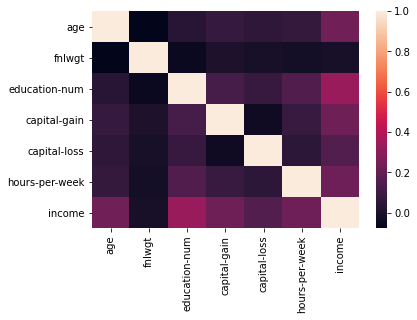

In [16]:
corr_num=df_temp.corr()
sns.heatmap(corr_num)

### Age:

The age is right-skewed (-1 year olds can't hold a job, for one)

The mean age of the study participant was 38 years, and the standard deviation was 13.6

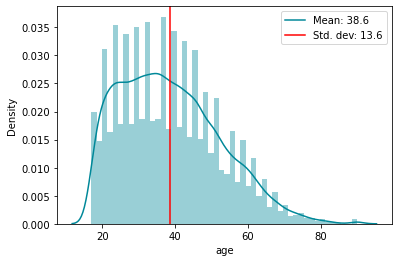

In [26]:
sns.distplot(X_train['age'], color='#008899')
plt.axvline(X_train['age'].mean(), 0, 1, color='red')
mean=round(X_train['age'].mean(),1)
std_deviation=round(X_train['age'].std(),1)
plt.legend(labels=["Mean: {}".format(mean), "Std. dev: {}".format(std_deviation)])

Remember that a salary higher than $50K is equivalent to True, in our dataset.
As you may have already guessed, a >50K salary is correlated to a higher age, considering the median and IQR.

<AxesSubplot:xlabel='income', ylabel='age'>

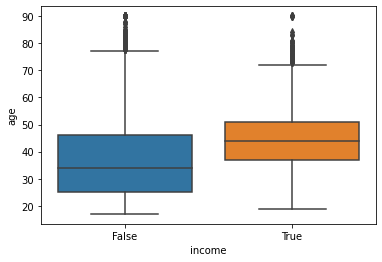

In [25]:
sns.boxplot(x='income', y='age', data=df_temp)

### Hours per week worked:

Let's examine how the frequency distribution of how many hours people worked per week:

Text(0.5, 1.0, 'Hours per week Frequency Dist.')

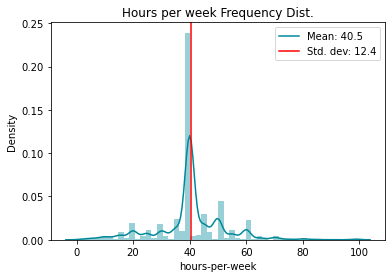

In [27]:
sns.distplot(X_train['hours-per-week'], color='#008899')
plt.axvline(X_train['hours-per-week'].mean(), 0, 1, color='red')
mean=round(X_train['hours-per-week'].mean(),1)
std_deviation=round(X_train['hours-per-week'].std(),1)
plt.legend(labels=["Mean: {}".format(mean), "Std. dev: {}".format(std_deviation)])
plt.title('Hours per week Frequency Dist.')

All we can tell is that the vast majority of those sampled, work about 40 hours per week, with some working less/more. What is interesting, is that there are gaps between the hours worked. Perhaps this implies a bias in people's memory (estimating in terms of 5s/10s is easier), or more companies are willing to make someone work h hours such that h%5=0, or both!

<AxesSubplot:xlabel='income', ylabel='hours-per-week'>

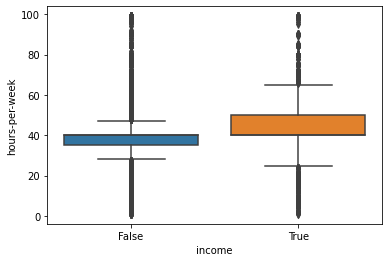

In [28]:
sns.boxplot(x='income', y='hours-per-week', data=df_temp)

It appears that making more money is in fact correlated to working for more hours

### Education number of years:

Text(0.5, 1.0, 'Density function of number of years of education')

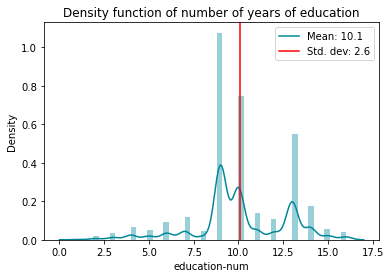

In [30]:
sns.distplot(X_train['education-num'], color='#008899')
plt.axvline(X_train['education-num'].mean(), 0, 1, color='red')
mean=round(X_train['education-num'].mean(),1)
std_deviation=round(X_train['education-num'].std(),1)
plt.legend(labels=["Mean: {}".format(mean), "Std. dev: {}".format(std_deviation)])
plt.title('Density function of number of years of education')

In [32]:
min(X_train['age'])

17

This is quite challenging to interpret soleley because I do not have more details of how this feature's data was gathered. Given that the minimum age implies that children were not asked, I'm not sure why this data is in general, low. Nonetheless, let's continue, to see how the differences in education length, correlate to a higher income:

<AxesSubplot:xlabel='income', ylabel='education-num'>

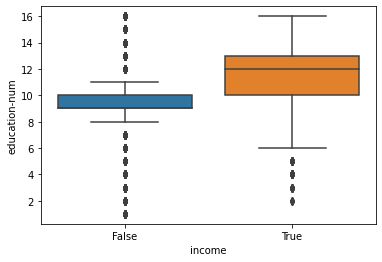

In [33]:
sns.boxplot(x='income', y='education-num', data=df_temp)

## 1.3: Data Visualization of Categorical variables

Text(0.5, 1.0, 'Occupation')

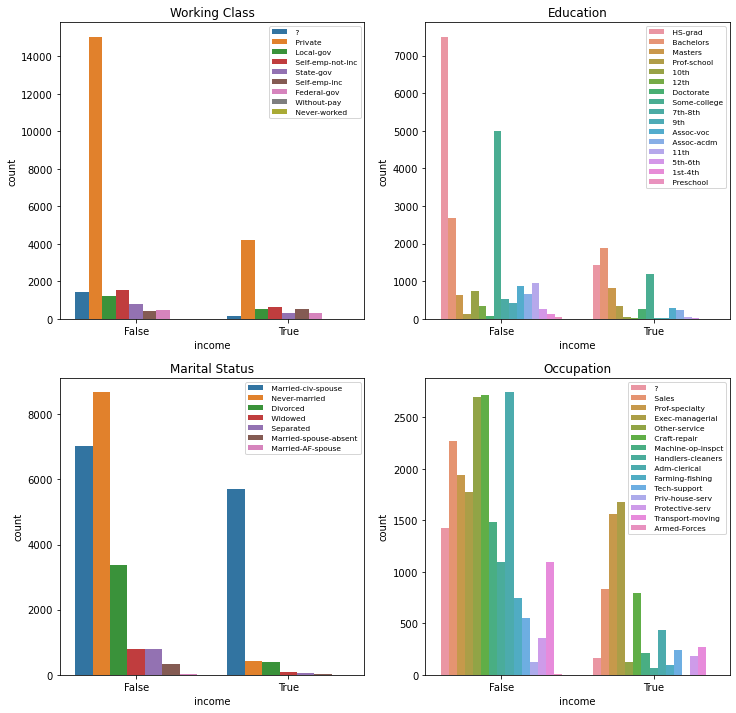

In [39]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
plot1=sns.countplot(x='income', hue='workclass', data=df_temp, ax=ax[0,0])
plot1.legend(loc='upper right',fontsize = 7.5)
plot1.set_title('Working Class')
plot2=sns.countplot(x='income', hue='education', data=df_temp, ax=ax[0,1])
plot2.legend(fontsize = 7.5, loc='upper right')
plot2.set_title('Education')
plot3=sns.countplot(x='income', hue='marital-status', data=df_temp, ax=ax[1,0])
plot3.legend(loc='upper right', fontsize = 7.5)
plot3.set_title('Marital Status')
plot4=sns.countplot(x='income', hue='occupation', data=df_temp, ax=ax[1,1])
plot4.legend(fontsize = 7.5, loc='upper right')
plot4.set_title('Occupation')

It's clear that the vast majority of the people in this set are grouped into 'private'. It looks like Self-emp-inc (self employed in a business) have an advantage, but we will analyze the correlation later after One hot encoding variables.

Text(0.5, 1.0, 'Native-Country')

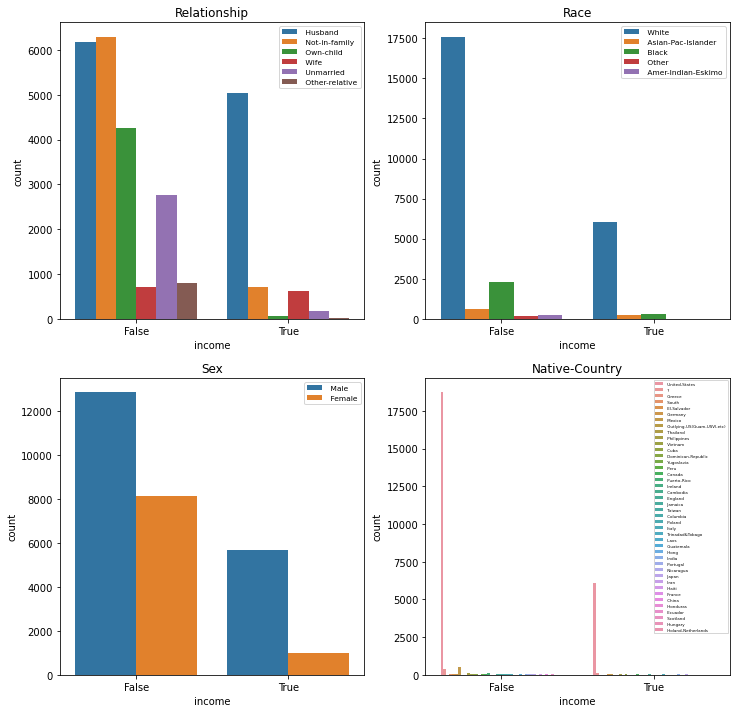

In [38]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
plot1=sns.countplot(x='income', hue='relationship', data=df_temp, ax=ax[0,0])
plot1.legend(loc='upper right',fontsize = 7.5)
plot1.set_title('Relationship')
plot2=sns.countplot(x='income', hue='race', data=df_temp, ax=ax[0,1])
plot2.legend(fontsize = 7.5, loc='upper right')
plot2.set_title('Race')
plot3=sns.countplot(x='income', hue='sex', data=df_temp, ax=ax[1,0])
plot3.legend(loc='upper right', fontsize = 7.5)
plot3.set_title('Sex')
plot4=sns.countplot(x='income', hue='native-country', data=df_temp, ax=ax[1,1])
plot4.legend(fontsize = 4, loc='upper right')
plot4.set_title('Native-Country')

What is immediately obvious is that, being a white, male, husband correlates the most to having a >$50K salary. These relationships will be looked at in more detail during dimensionality reduction.
What is also clear is that the vast majority of respondents were originall from United States

## 1.4: Preprocessing Data pt. 2
It's time to one-hot encode our data

In [12]:
#Use this for faster processing. We will be analyzing the columns however, so we will transform back to a dataframe.
def ohe_to_array(df):
    col_transformer_min_max=ColumnTransformer([('one_hot', OneHotEncoder(), list_objs), #Run OHE on categorical variables only
                                                ('min_max', StandardScaler(), list_nums)])
    sparse_arr=col_transformer_min_max.fit_transform(df)
    train_data=sparse_arr.toarray()
    return train_data

In [13]:
def ohe_to_df(X_train, X_test):
    global list_objs, list_nums
    list_nums=[column for column in X_train.columns if X_train[column].dtype==np.dtype('int')]
    list_objs=[column for column in X_train.columns if X_train[column].dtype==np.dtype('O')]
    ohe=OneHotEncoder()
    arr1_sparse=ohe.fit_transform(X_train[list_objs])
    arr2_sparse=ohe.transform(X_test[list_objs])
    arr1=arr1_sparse.toarray()
    arr2=arr2_sparse.toarray()
    df1=pd.DataFrame(arr1, columns=ohe.get_feature_names())
    df2=pd.DataFrame(arr2, columns=ohe.get_feature_names())
    X_train=pd.merge(df1,X_train[list_nums], left_index=True, right_index=True)
    X_test=pd.merge(df2,X_test[list_nums], left_index=True, right_index=True)
    return X_train, X_test

X_train, X_test=ohe_to_df(X_train,X_test)
X_train.iloc[0:3]

,x0_ ?,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,x0_ Self-emp-inc,x0_ Self-emp-not-inc,x0_ State-gov,x0_ Without-pay,x1_ 10th,...,x7_ Trinadad&Tobago,x7_ United-States,x7_ Vietnam,x7_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,59,160662,9,2407,0,60
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,50,209320,13,0,0,40
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,47,228372,14,0,0,48


As you can tell, the columns have very strange names so I built a function to transform the names such that the (n-1) x value is switched with the previous column name in the nth position

In [14]:
def rename_columns(X_train, X_test):
    for i in X_train.columns:
        if len(i.split('_'))>1:
            try:
                index=int(i.split('_')[0][-1])
                X_train.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
                X_test.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
            except Exception as x:
                print(x)

rename_columns(X_train, X_test)
X_train.iloc[:3]

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,59,160662,9,2407,0,60
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,50,209320,13,0,0,40
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,47,228372,14,0,0,48


## 2.0: Correlation Analysis
Let's first compare the income variable with every feature by using correlation, and then do so using Random forest feature importance, then keep the union of the most important features

First we create a correlation array relative to the target

In [15]:
corr_arr=X_train.corrwith(y_train)

I will now add tuples containing all features that start with a keyword of a column (workclass for example), and the correlation of said feature with the income variable.

In [16]:
dict_index={}
list_keywords=['workclass_','education_','marital-status_', 'occupation_','relationship_','race_','sex_', 'native-country_', 'age','fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
for i in list_keywords:
    dict_index[i]=[(ind, round(corr_arr[ind],2)) for ind in corr_arr.index if i in ind]

#### Working Class:
Interestingly enough, whether or not someone is self employed in a corporate entity setting, is the best predictor of whether or not they will be payed more than $50K:

In [17]:
dict_index['workclass_']

[('workclass_ ?', -0.08),
 ('workclass_ Federal-gov', 0.06),
 ('workclass_ Local-gov', 0.03),
 ('workclass_ Never-worked', -0.01),
 ('workclass_ Private', -0.08),
 ('workclass_ Self-emp-inc', 0.14),
 ('workclass_ Self-emp-not-inc', 0.03),
 ('workclass_ State-gov', 0.02),
 ('workclass_ Without-pay', -0.01)]

#### Education:
It's clear that getting a Masters, Bachelors, or Doctorate, is of utmost importance if you want to make a decent wage above 50K. However it appears that getting a Bachelors or Masters is more highly correlated with having a >$50K salary than having a Doctorate

In [50]:
dict_index['education_']

[('education_ 10th', -0.07),
 ('education_ 11th', -0.09),
 ('education_ 12th', -0.05),
 ('education_ 1st-4th', -0.03),
 ('education_ 5th-6th', -0.05),
 ('education_ 7th-8th', -0.06),
 ('education_ 9th', -0.06),
 ('education_ Assoc-acdm', 0.01),
 ('education_ Assoc-voc', 0.01),
 ('education_ Bachelors', 0.18),
 ('education_ Doctorate', 0.13),
 ('education_ HS-grad', -0.13),
 ('education_ Masters', 0.18),
 ('education_ Preschool', -0.02),
 ('education_ Prof-school', 0.16),
 ('education_ Some-college', -0.06)]

#### Relationship:
Perhaps it's good to marry, or perhaps the younger folks who make less money simply are creating a bias in our data. What is surprising, however, is that income is correlated to whether or not your spouse is in the armed forces, a civilian, or if you divorced.

In [51]:
dict_index['marital-status_']

[('marital-status_ Divorced', -0.13),
 ('marital-status_ Married-AF-spouse', 0.01),
 ('marital-status_ Married-civ-spouse', 0.45),
 ('marital-status_ Married-spouse-absent', -0.04),
 ('marital-status_ Never-married', -0.32),
 ('marital-status_ Separated', -0.07),
 ('marital-status_ Widowed', -0.07)]

I'm not going to show the output for the rest, for the sake of keeping the notebook neat, but it's easy to see/verify that:
Being in an executive/managerial position or having a specialty job, being a male in a relationship, being white (has a slight correlation), being from the United States (especially not being from Mexico),
level of education, capital gain/loss, age, and hours worked per week is the most correlated with having a >50K salary. Surprisingly, whether or not you were a male, and whether or not you were currently married to a civilian, had the greatest correlation to the higher salary.

Let's now narrow down which features we think may be of the most importance in making our calculations. Here we attain 24 features

In [18]:
columns_keep=list(corr_arr[abs(corr_arr)>0.1].index) #If they have an absolute value of greater than .1:
print('# features: {}'.format(len(columns_keep)),'\n', columns_keep)

# features: 24 
 ['workclass_ Self-emp-inc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Prof-school', 'marital-status_ Divorced', 'marital-status_ Married-civ-spouse', 'marital-status_ Never-married', 'occupation_ Exec-managerial', 'occupation_ Other-service', 'occupation_ Prof-specialty', 'relationship_ Husband', 'relationship_ Not-in-family', 'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'sex_ Female', 'sex_ Male', 'age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


## 2.1: Random Forest Analysis
I will create a random forest to extract the most important features, and then compare them to the correlation analysis

In [19]:
rnd_features=RandomForestClassifier(n_estimators=300, n_jobs=-1)
rnd_features.fit(X_train, y_train)
feature_importance=rnd_features.feature_importances_
feature_importance_dict=set(zip(X_train.columns, feature_importance))
feature_importance_df=pd.DataFrame().from_dict(feature_importance_dict)
feature_importance_list=list(feature_importance_df.sort_values(1, ascending=False).iloc[:24,0]) #Sort the dataframe by the feature importance and choose the 24 highest (equal to that of correlation analysis)

In [20]:
print(feature_importance_list)

['fnlwgt', 'age', 'capital-gain', 'hours-per-week', 'education-num', 'marital-status_ Married-civ-spouse', 'relationship_ Husband', 'capital-loss', 'marital-status_ Never-married', 'occupation_ Exec-managerial', 'occupation_ Prof-specialty', 'relationship_ Not-in-family', 'education_ Bachelors', 'workclass_ Private', 'relationship_ Own-child', 'sex_ Male', 'relationship_ Wife', 'sex_ Female', 'workclass_ Self-emp-not-inc', 'education_ HS-grad', 'education_ Masters', 'occupation_ Sales', 'occupation_ Craft-repair', 'marital-status_ Divorced']


Let's see how many of our features were shared between the correlation analysis and the random forest:

In [21]:
n=0
for i in columns_keep:
    if i in feature_importance_list:
        n+=1
print(n)

19


They seem to agree on the most important features

Now let's add every column value that isn't in the columns_keep class already, from our newly made one:

## 2.2: Dimensionality Reduction

In [22]:
[columns_keep.append(col) for col in feature_importance_list if col not in columns_keep]

[None, None, None, None, None]

Let's now replace our old sets of data

In [23]:
X_train=X_train[columns_keep]
X_test=X_test[columns_keep]

We have reduced the number of features by 79 (108 to 29)! As we will see, the performance is nearly identical despite having nearly 1/4th of the dimensions

## 3.0 Functions for Classification:

Let's now create functions to interpret how good our models will be, using an ROC curve, AUC, recall, precision, accuracy, and the F1 score, and dictionary to compare our models when we finish.

In [62]:
#I will store the f1 and accuracy scores of training and test set for every model in this:
clf_scores={}

#Function to plot the ROC:
def plt_roc(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.legend()
    plt.title('train set')
    plt.show()

#This will be our main function from which we call plt_roc. It will computer various metrics and store the necessary values in clf_scores dict.
def show_scores(model,X_train,y_train,X_test,y_test):
    global clf_scores
    #Calculate scores
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    acc_train=accuracy_score(y_train, y_pred_train)
    acc_test=accuracy_score(y_test, y_pred_test)
    f1_train=f1_score(y_train, y_pred_train)
    f1_test=f1_score(y_test, y_pred_test)

    print('Accuracy on train set = ',acc_train)
    print('Recall on train set = ',recall_score(y_train, y_pred_train))
    print('Precision on train set = ',precision_score(y_train, y_pred_train), '\n')
    print('Accuracy on test set = ',acc_test)
    print('Recall on test set = ',recall_score(y_test, y_pred_test))
    print('Precision on test set = ',precision_score(y_test, y_pred_test,'\n'))

    #Determine the name to use for our dictionary. If it is a gridsearch object then check if it contains a pipeline, otherwise pring the name of the model and gather the scores.
    if type(model).__name__=='GridSearchCV':
        if type(model.best_estimator_).__name__ == 'Pipeline':
            clf_scores[type(model.best_estimator_[-1]).__name__]=(acc_train, f1_train , acc_test, f1_test)   
        else:
            clf_scores[type(model).__name__]=(acc_train, f1_train , acc_test, f1_test)

    elif type(model).__name__ == 'Pipeline':
        clf_scores[type(model.best_estimator_[-1]).__name__]=(acc_train, f1_train , acc_test, f1_test)
    else:
        clf_scores[type(model).__name__]=(acc_train, f1_train , acc_test, f1_test)

    #For some models we can find the decision function, for others we can't, so use try:

    try:
        y_scores=model.decision_function(X_train)
        fpr,tpr, thresholds=roc_curve(y_pred_train, y_scores)
        label=list(model.best_estimator_.named_steps.keys())[-1]
        plt_roc(fpr, tpr, label)
        print('Area under curve for train set:',round(roc_auc_score(y_train, y_scores),3), 'out of 1')
    except Exception as x:
        print('\n',x)

## 3.1: LogisticRegression
We will now use a grid search to hone in on decent regularization parameters. It probably won't make much difference depending on the scaling technique, but we will try MinMax and Standard Scaling anyways to see which one may be best suited for our model.

In [27]:
pipe_logreg=Pipeline([('scaler',MinMaxScaler()), ('logistic_reg', LogisticRegression(max_iter=1000))])
parameters=[{'scaler':[StandardScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4,1e-3]},
            {'scaler':[MinMaxScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4, 1e-3]}]
grid_search_logreg = GridSearchCV( pipe_logreg, parameters, n_jobs=-1)
grid_search_logreg.fit(X_train,y_train)
grid_search_logreg.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_reg',
                 LogisticRegression(C=1, max_iter=1000, tol=1e-05))])

Let's check our scores:

Accuracy on train set =  0.8490388784506432
Recall on train set =  0.5834958739684921
Precision on train set =  0.7350217350217351 

Accuracy on test set =  0.8491299897645854
Recall on test set =  0.5833333333333334
Precision on test set =  0.7352625937834941


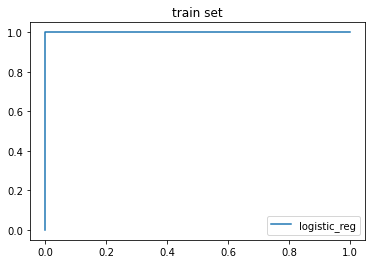

Area under curve for train set: 0.904 out of 1


In [63]:
show_scores(grid_search_logreg, X_train, y_train, X_test, y_test)

As you can tell, it seems that the model is struggling with identifying True positives in such a way that implies that our threshold may be suboptimal. We are, however, not trying to determine the optimal model, and will not change the threshold value. The complete lack of overfitting is astounding.

.852 accuracy score without Dim reduction, and .849 despite nearly 1/4th of the number of features! Let's now check our dict.:

In [64]:
clf_scores

{'LogisticRegression': (0.8490388784506432,
  0.6505520240883239,
  0.8491299897645854,
  0.6505452821242296)}

## 3.2: SVCs
We will test between linearSVC and SVC with various kernels besides linear (since SVC(kernel='linear') is generally much slower (O(m**2xn) vs O(mxn))

In [30]:
pipe_SVC=Pipeline([('scaler',StandardScaler()),('svc',LinearSVC())])
parameters_svc=[{'scaler':[StandardScaler()], 'svc':[LinearSVC()], 'svc__penalty':['l2'], 'svc__C':[10,1,1e-1]},
            {'scaler':[StandardScaler()], 'svc':[SVC()], 'svc__kernel':['poly', 'rbf'], 'svc__degree':[2,3], 'svc__C':[10,1,1e-1]}]
grid_search_SVC=GridSearchCV(pipe_SVC,parameters_svc, n_jobs=-1)
grid_search_SVC.fit(X_train, y_train)
grid_search_SVC.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=1, degree=2))])

Accuracy on train set =  0.8603121838415956
Recall on train set =  0.6019504876219055
Precision on train set =  0.7678468899521531 

Accuracy on test set =  0.8528147389969294
Recall on test set =  0.5790816326530612
Precision on test set =  0.7524861878453039


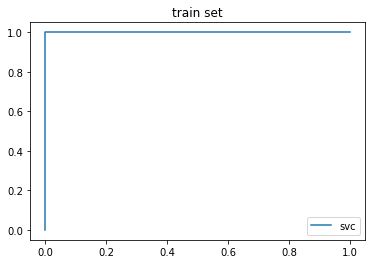

Area under curve for train set: 0.912 out of 1


In [65]:
show_scores(grid_search_SVC, X_train, y_train, X_test, y_test)

It seems that given the area under the curve, the SVC with rbf kernel is slightly better suited than the logistic classifier!

## 3.3: Decision Tree
Let's now create a decision tree with min_samples_split 1% of the training set size.

In [40]:
d_tree=DecisionTreeClassifier(criterion='gini', min_samples_split=int(len(X_train)*.01))
d_tree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=276)

In [67]:
show_scores(d_tree, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8675025292672351
Recall on train set =  0.6373593398349587
Precision on train set =  0.7726445980356493 

Accuracy on test set =  0.857727737973388
Recall on test set =  0.6037414965986394
Precision on test set =  0.7561235356762513

 'DecisionTreeClassifier' object has no attribute 'decision_function'


## 4.0: Random Forests

In [73]:
rnd_fc=RandomForestClassifier(n_estimators=250, min_samples_split=20,n_jobs=-1)
rnd_fc.fit(X_train, y_train)
show_scores(rnd_fc, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.9101026159849689
Recall on train set =  0.727231807951988
Precision on train set =  0.8785571868769259 

Accuracy on test set =  0.860388945752303
Recall on test set =  0.6113945578231292
Precision on test set =  0.7616525423728814

 'RandomForestClassifier' object has no attribute 'decision_function'


In [70]:
#The rnd_clf implies that the most important factors in determining whether or not you will make over $50K per year are your age, education, capital gain, and whether or not you are a husband in a healthy marriage!!!
set(zip(X_train.columns,rnd_fc.feature_importances_))

{('age', 0.11296309086505833),
 ('capital-gain', 0.1575620937138889),
 ('capital-loss', 0.04527074064052727),
 ('education-num', 0.12171165714085197),
 ('education_ Bachelors', 0.013900612406624721),
 ('education_ Doctorate', 0.0037703724535169806),
 ('education_ HS-grad', 0.007601449523620308),
 ('education_ Masters', 0.007755421584838724),
 ('education_ Prof-school', 0.005445044691484345),
 ('fnlwgt', 0.08017862177759416),
 ('hours-per-week', 0.06823345581067812),
 ('marital-status_ Divorced', 0.00536756611349807),
 ('marital-status_ Married-civ-spouse', 0.1236694773606547),
 ('marital-status_ Never-married', 0.030700725668746227),
 ('occupation_ Craft-repair', 0.0050683325934056216),
 ('occupation_ Exec-managerial', 0.02545616410158411),
 ('occupation_ Other-service', 0.0074955374313042614),
 ('occupation_ Prof-specialty', 0.01920628820272198),
 ('occupation_ Sales', 0.006542556345712965),
 ('relationship_ Husband', 0.07757055628706566),
 ('relationship_ Not-in-family', 0.0095700313

## 4.1: Voting classifier

We will look at the soft margin and hard margin classifiers

In [76]:
# Let's use the best params from our grid search to build an SVC that can predict probabilities of an instance belonging to the positive class. The scores are identical to the previous grid search with SVC
pipe_SVC_prob=Pipeline([('scaler',StandardScaler()),('svc',SVC(C=1, kernel='rbf', probability=True))])
pipe_SVC_prob.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, probability=True))])

In [77]:
#Surprisingly, the voting classifier actually underperforms the plain rbf kernel SVC!
voting_clf_soft=VotingClassifier(estimators=[('lr',grid_search_logreg), ('svc', pipe_SVC_prob)], voting='soft')
voting_clf_soft.fit(X_train, y_train)
show_scores(voting_clf_soft, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8585416967769909
Recall on train set =  0.5930982745686422
Precision on train set =  0.7666795965865012 

Accuracy on test set =  0.8509723643807574
Recall on test set =  0.5680272108843537
Precision on test set =  0.7522522522522522

 'VotingClassifier' object has no attribute 'decision_function'


In [78]:
voting_clf_hard=VotingClassifier(estimators=[('lr',grid_search_logreg), ('svc', pipe_SVC_prob), ('rfc', rnd_fc)], voting='hard')
voting_clf_hard.fit(X_train, y_train)
show_scores(voting_clf_hard, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8694175458881341
Recall on train set =  0.6214553638409602
Precision on train set =  0.7915153831454232 

Accuracy on test set =  0.8564994882292732
Recall on test set =  0.592687074829932
Precision on test set =  0.7584330794341676

 'VotingClassifier' object has no attribute 'decision_function'


The Random Forest Classifier still outperforms this classifier

## 4.2 Bagging Classifier

In [80]:
bg_clf=BaggingClassifier(DecisionTreeClassifier(criterion='gini', min_samples_split=25), n_estimators=300, max_samples=X_train.shape[0], n_jobs=-1, bootstrap=True)
bg_clf.fit(X_train, y_train)
show_scores(bg_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.9175097557450499
Recall on train set =  0.7465866466616654
Precision on train set =  0.8933572710951526 

Accuracy on test set =  0.8595701125895598
Recall on test set =  0.6156462585034014
Precision on test set =  0.755741127348643

 'DecisionTreeClassifier' object has no attribute 'decision_function'


We were able to extract a performance boost using a bagging classifier vs the plain decision Tree clf!

## 4.3 Gradient Boosting

In [83]:
gb_clf=GradientBoostingClassifier(n_estimators=500, random_state=1)
gb_clf.fit(X_train, y_train)
show_scores(gb_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8839427662957074
Recall on train set =  0.6666166541635409
Precision on train set =  0.8177802319160685 

Accuracy on test set =  0.8704196519959059
Recall on test set =  0.6428571428571429
Precision on test set =  0.7801857585139319

 'GradientBoostingClassifier' object has no attribute 'best_estimator_'


It is surprisingly hard to overfit this classifier

## 4.4 Stacking:

In [85]:
stacking_clf=StackingClassifier(estimators=[('log_reg', grid_search_logreg),
                                            ('svc_rbf', grid_search_SVC),
                                            ('dec_tree',d_tree),
                                            ('random_forest', rnd_fc),
                                            ('grad_boosting', gb_clf)],
                                            final_estimator=LogisticRegression(), n_jobs=-1, verbose=2)
stacking_clf.fit(X_train, y_train)
show_scores(stacking_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8887483740424917
Recall on train set =  0.6783195798949737
Precision on train set =  0.8286290322580645 

Accuracy on test set =  0.8710337768679631
Recall on test set =  0.6394557823129252
Precision on test set =  0.7849686847599165

 'StackingClassifier' object has no attribute 'best_estimator_'


In [91]:
df_clf=pd.DataFrame(clf_scores, index=['accuracy_train', 'f1_train', 'accuracy_test', 'f1_test'])
df_clf.to_csv('clf_scores')
df_clf

,LogisticRegression,SVC,DecisionTreeClassifier,RandomForestClassifier,VotingClassifier,BaggingClassifier,GradientBoostingClassifier,StackingClassifier
accuracy_train,0.849039,0.860312,0.867503,0.910103,0.869418,0.917510,0.883943,0.888748
f1_train,0.650552,0.674853,0.698512,0.795764,0.696251,0.813404,0.734502,0.745978
accuracy_test,0.849130,0.852815,0.857728,0.860389,0.856499,0.859570,0.870420,0.871034
f1_test,0.650545,0.654493,0.671395,0.678302,0.665394,0.678538,0.704895,0.704780


## 5.0: Preprocessing for Ensemble Neural Net

This allows me to use a custom input from the previous models that we trained. Please note that my TF version was incompatible with some other packages because I'm using a pre-production version of Tensorflow for the new Mac M1 chip. So I had save my data and change my environment to run this. That is why you will see me saving then loading the data.

Let's import our packages:

In [1]:
import tensorflow as tf
from tensorflow import keras

Let's create a validation set out of our training set so we can use EarlyCallback:

In [92]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train, y_train, test_size=0.17, stratify=y_train)

In [93]:
y_train_nn.reset_index(drop=True, inplace=True)
y_valid_nn.reset_index(drop=True, inplace=True)

I'm going to process our training, validation, and test set data by creating the predictions output using our previously trained classifiers. I will choose for them to predict proba (if they have that method) because that should be more useful for our training set.

In [94]:
def create_df_4_NN(df):
    df_NN=pd.DataFrame(grid_search_logreg.predict_proba(df)[:,0])
    for model in [pipe_SVC_prob, d_tree, rnd_fc, gb_clf]:
        if hasattr(model, 'predict_proba'):
            df_temp=pd.DataFrame(model.predict_proba(df)[:,0])
        else:
            df_temp=pd.DataFrame(model.predict(df))
        df_NN=pd.merge(df_NN,df_temp, right_index=True, left_index=True)
    return df_NN

I will save them to be able to run from a separate environment later (explanation above)

In [95]:
X_train_nn=create_df_4_NN(X_train_nn)
X_train_nn=pd.merge(X_train_nn, y_train_nn, left_index=True, right_index=True)
X_train_nn.to_csv('training_set_NN')

X_valid_nn=create_df_4_NN(X_valid_nn)
X_valid_nn=pd.merge(X_valid_nn, y_valid_nn, left_index=True, right_index=True)
X_valid_nn.to_csv('validation_set_NN')

X_test_nn=create_df_4_NN(X_test)
X_test_nn=pd.merge(X_test_nn, y_test, left_index=True, right_index=True)
X_test_nn.to_csv('test_set_NN')

In [97]:
X_train_nn

,0_x,0_y,0_x,0_y,0,income
0,0.996036,0.929048,1.000000,0.993504,0.995261,False
1,0.072417,0.106945,0.000000,0.054596,0.013789,True
2,0.914020,0.872509,0.937500,0.920090,0.893023,False
3,0.174229,0.147705,0.000000,0.008224,0.008968,True
4,0.997353,0.960994,1.000000,0.999692,0.997379,False
...,...,...,...,...,...,...
22966,0.790381,0.857804,0.783465,0.614950,0.667470,True
22967,0.261776,0.145752,0.200000,0.194240,0.266616,True
22968,0.379937,0.678520,0.717172,0.595766,0.635933,False
22969,0.961217,0.887678,0.960591,0.929646,0.981710,False


Let's gather our inputs from before: 

In [3]:
def read_df():
    train_nn = pd.read_csv('training_set_NN', index_col=0)
    valid_nn = pd.read_csv('validation_set_NN', index_col=0)
    test_nn = pd.read_csv('test_set_NN', index_col=0)
    X_train_nn = np.array(train_nn.loc[:,:'0'])
    y_train_nn = train_nn['income']
    X_valid_nn = np.array(valid_nn.loc[:,:'0'])
    y_valid_nn = valid_nn['income']
    X_test_nn = np.array(test_nn.loc[:,:'0'])
    y_test_nn = test_nn['income']
    return X_train_nn, X_valid_nn, X_test_nn, y_train_nn, y_valid_nn, y_test_nn

In [129]:
X_train_nn, X_valid_nn, X_test_nn, y_train_nn, y_valid_nn, y_test_nn = read_df()
clf_scores=pd.read_csv('clf_scores', index_col=0)

I don't want the targets to be Boolean, but I want them to be 1 if True or 0 if False

In [5]:
y_train_nn=np.array(y_train_nn*1)
y_valid_nn=np.array(y_valid_nn*1)
y_test_nn=np.array(y_test_nn*1)

Like so:

In [7]:
y_train_nn[0:7]

array([0, 1, 0, 1, 0, 0, 1])

## 5.1: Stacking with custom Neural Network

Let's now create the Neural net:

In [143]:
now=datetime.now()
callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=7)] #Let's test our training model on our validation set using Early stopping
optimizer=keras.optimizers.Adam() #If you have slow hardware, you can try using the Adam optimizer, but 'sgd' should work just fine

metric = tf.keras.metrics.Recall() # I am more concerned about recall than accuracy, so we will use this instead

nn_model=keras.models.Sequential([keras.Input(shape=(5,))])

#5 layer deep neural net (Probably overkill since our input dimensions are simple)
for i in range(5):
    nn_model.add(keras.layers.BatchNormalization()) #Probably not necessary since our data is already somewhat scaled (0-1), but let's use it anyways to avoid EG
    keras.layers.Dropout(rate=0.65) #For regularization. Around a quarter of connection weights are set to zero for each training step
    nn_model.add(keras.layers.Dense(60, activation='elu', kernel_initializer='he_normal', 
                                    kernel_regularizer=keras.regularizers.l2(.01))) #kernel initializer is probably not necessary since                                                                                                                                                          #we don't have to worry about exploding gradients as this nn is not very deep
nn_model.add(keras.layers.Dense(1, activation='sigmoid'))

#Let's compile the model and recall that we are focusing on the recall 
nn_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[metric])

hist=nn_model.fit(X_train_nn, y_train_nn, epochs=30, validation_data=(X_valid_nn, y_valid_nn))
print(datetime.now()-now)

Epoch 1/30
718/718 [==============================] - 2s 2ms/step - loss: 6.2770 - recall_81: 0.8619 - val_loss: 6.1962 - val_recall_81: 0.8508
Epoch 2/30
718/718 [==============================] - 1s 2ms/step - loss: 6.1997 - recall_81: 0.8714 - val_loss: 6.1958 - val_recall_81: 0.2992
Epoch 3/30
718/718 [==============================] - 1s 2ms/step - loss: 6.1996 - recall_81: 0.8740 - val_loss: 6.1919 - val_recall_81: 0.2913
Epoch 4/30
718/718 [==============================] - 1s 2ms/step - loss: 6.1956 - recall_81: 0.8671 - val_loss: 6.1880 - val_recall_81: 0.2913
Epoch 5/30
718/718 [==============================] - 1s 2ms/step - loss: 6.1955 - recall_81: 0.8765 - val_loss: 6.1876 - val_recall_81: 0.2860
Epoch 6/30
718/718 [==============================] - 1s 2ms/step - loss: 6.1947 - recall_81: 0.8732 - val_loss: 6.1850 - val_recall_81: 0.2992
Epoch 7/30
718/718 [==============================] - 1s 2ms/step - loss: 6.1972 - recall_81: 0.8820 - val_loss: 6.1858 - val_recall_81:

In [106]:
nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 5)                 20        
_________________________________________________________________
dense_42 (Dense)             (None, 60)                360       
_________________________________________________________________
batch_normalization_37 (Batc (None, 60)                240       
_________________________________________________________________
dense_43 (Dense)             (None, 60)                3660      
_________________________________________________________________
batch_normalization_38 (Batc (None, 60)                240       
_________________________________________________________________
dense_44 (Dense)             (None, 60)                3660      
_________________________________________________________________
batch_normalization_39 (Batc (None, 60)               

## 5.2: Scoring for Neural Net

Our output will look as follows: 

In [14]:
nn_model.predict(X_test_nn)[0:4]

array([[1.7253098e-05],
       [3.1098095e-01],
       [1.8508348e-05],
       [6.3452264e-04]], dtype=float32)

I will create a custom score function such that if the model predicts a value of >.5, then it will predict 1

In [19]:
((nn_model.predict(X_test_nn)>.5)*1)[:3]

array([[0],
       [0],
       [0]])

In [120]:
def show_scores_nn(model, X_train, y_train, X_test, y_test, X_valid, y_valid):
    y_pred_train=(nn_model.predict(X_train)>.5)*1
    y_pred_test=(nn_model.predict(X_test)>.5)*1
    y_pred_valid=(nn_model.predict(X_valid)>.5)*1
    
    #I will re-initialize the tensorflow objects, because they act as if warm_start=True
    accuracy_function = tf.keras.metrics.Accuracy() #Accuracy function, etc.
    recall_function = tf.keras.metrics.Recall()
    precision_function = tf.keras.metrics.Precision()
    acc_train=accuracy_function(y_train, y_pred_train)
    prec_train=precision_function(y_train, y_pred_train)
    rec_train=recall_function(y_train, y_pred_train)
    f1_train=2*(prec_train * rec_train) / (prec_train + rec_train)
    print('Accuracy on train set = '), tf.print(acc_train)
    print('Recall on train set = '), tf.print(rec_train)
    print('Precision on train set = ') , tf.print(prec_train, '\n')


    accuracy_function = tf.keras.metrics.Accuracy()
    recall_function = tf.keras.metrics.Recall()
    precision_function = tf.keras.metrics.Precision()
    print('Accuracy on val. set = '), tf.print(accuracy_function(y_valid, y_pred_valid))
    print('Recall on val. set = '), tf.print(recall_function(y_valid, y_pred_valid))
    print('Precision on val. set = '), tf.print(precision_function(y_valid, y_pred_valid), '\n')
    

    accuracy_function = tf.keras.metrics.Accuracy()
    recall_function = tf.keras.metrics.Recall()
    precision_function = tf.keras.metrics.Precision()
    rec_test=recall_function(y_test, y_pred_test)
    prec_test=precision_function(y_test, y_pred_test)
    acc_test=accuracy_function(y_test, y_pred_test)
    f1_test= 2*(prec_test * rec_test) / (prec_test  + rec_test)
    print('Accuracy on test set = '), tf.print(acc_test)
    print('Recall on test set = '), tf.print(rec_test)
    print('Precision on test set = '), tf.print(prec_test)

    return pd.DataFrame( [acc_train, f1_train, acc_test, f1_test], index=['accuracy_train', 'f1_train', 'accuracy_test', 'f1_test'], columns=['Neural Net Stack'])

In [144]:
df_nn=show_scores_nn(nn_model, X_train_nn, y_train_nn, X_test_nn, y_test_nn, X_valid_nn, y_valid_nn)

Accuracy on train set = 
0.949849784
Recall on train set = 
0.88973248
Precision on train set = 
0.900805295 

Accuracy on val. set = 
0.940488815
Recall on val. set = 
0.863195062
Precision on val. set = 
0.886672735 

Accuracy on test set = 
0.839304
Recall on test set = 
0.630102038
Precision on test set = 
0.679193377


In [151]:
clf_scores_2=pd.merge(clf_scores,df_nn, right_index=True, left_index=True)
clf_scores_2.to_csv('clf_scores_complete')

Our scores now look like the following:

In [150]:
clf_scores_2

,LogisticRegression,SVC,DecisionTreeClassifier,RandomForestClassifier,VotingClassifier,BaggingClassifier,GradientBoostingClassifier,StackingClassifier,Neural Net Stack
accuracy_train,0.849039,0.860312,0.867503,0.910103,0.869418,0.917510,0.883943,0.888748,0.949850
f1_train,0.650552,0.674853,0.698512,0.795764,0.696251,0.813404,0.734502,0.745978,0.895235
accuracy_test,0.849130,0.852815,0.857728,0.860389,0.856499,0.859570,0.870420,0.871034,0.839304
f1_test,0.650545,0.654493,0.671395,0.678302,0.665394,0.678538,0.704895,0.704780,0.653727


## 6.0: Model Analysis

Let's take a look at how each classifier performed ralative to the others:

I will change environments from tf-for-M1 compatible to the previous one, and load in the data

In [7]:
clf_scores_2=pd.read_csv('clf_scores_complete', index_col=0)
clf_scores_3=clf_scores_2.copy() #Copy just in case we want to go back to previous version

I need to transpose it to make it more easily readable for Seaborn:

In [35]:
clf_scores_3=clf_scores_3.T
clf_scores_3['model']=clf_scores_3.index #So I can call the x axis in seaborn 

In [38]:
clf_scores_3

,accuracy_train,f1_train,accuracy_test,f1_test,model
LogisticRegression,0.849039,0.650552,0.849130,0.650545,LogisticRegression
SVC,0.860312,0.674853,0.852815,0.654493,SVC
DecisionTreeClassifier,0.867503,0.698512,0.857728,0.671395,DecisionTreeClassifier
RandomForestClassifier,0.910103,0.795764,0.860389,0.678302,RandomForestClassifier
VotingClassifier,0.869418,0.696251,0.856499,0.665394,VotingClassifier
BaggingClassifier,0.917510,0.813404,0.859570,0.678538,BaggingClassifier
GradientBoostingClassifier,0.883943,0.734502,0.870420,0.704895,GradientBoostingClassifier
StackingClassifier,0.888748,0.745978,0.871034,0.704780,StackingClassifier
Neural Net Stack,0.949850,0.895235,0.839304,0.653727,Neural Net Stack


Now let's analyze the scores! 

Text(0.5, 1.0, 'F1 score on training set')

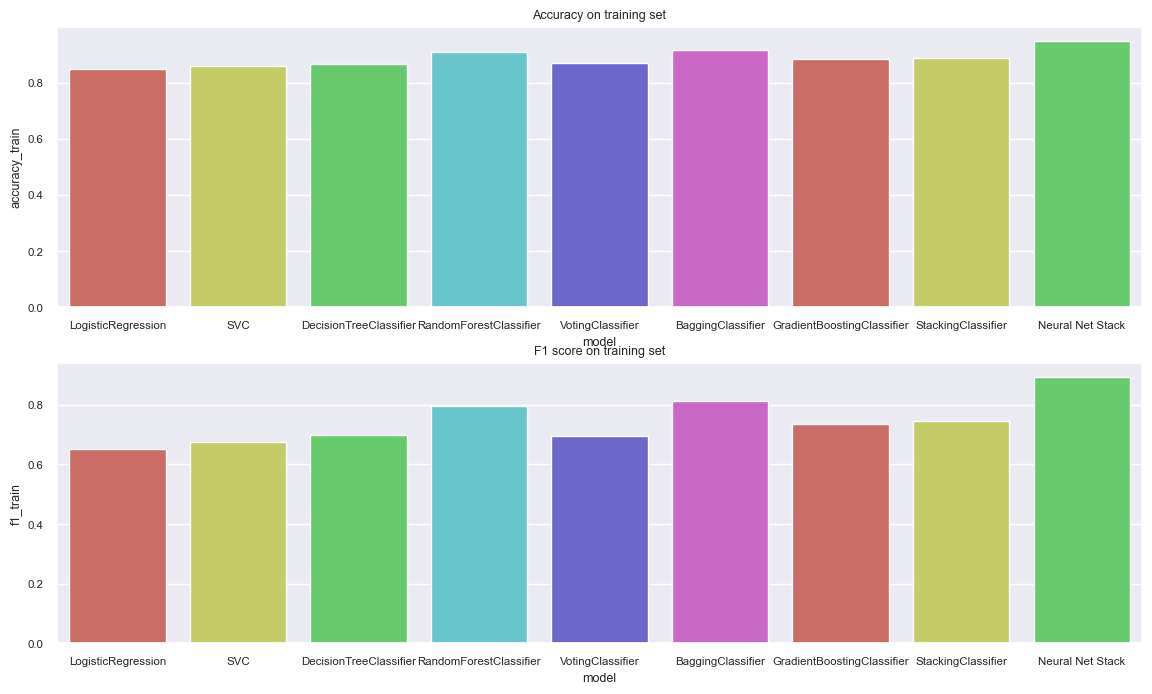

In [102]:
sns.set(font_scale = .75)
fig, ax = plt.subplots(2, figsize=(14,8))

plot1=sns.barplot( data=clf_scores_3, x='model', y='accuracy_train', ax=ax[0], palette=sns.color_palette('hls',6))
plot1.set_title('Accuracy on training set')

plot1=sns.barplot( data=clf_scores_3, x='model', y='f1_train', ax=ax[1], palette=sns.color_palette('hls',6))
plot1.set_title('F1 score on training set')

It looks like the neural network, and Bagging Classifier to an extent, is superior relative to the rest. Logistic Regression, SVC, GradientBoostingClassifier, and the Voting Classifier, seem to underperform relative to the rest. You may recall that the neural network was trained on a slightly smaller dataset, but please recall that it did just as well on the validation set. Let's now look at the scores on the test set:

Text(0.5, 1.0, 'F1 score on testing set')

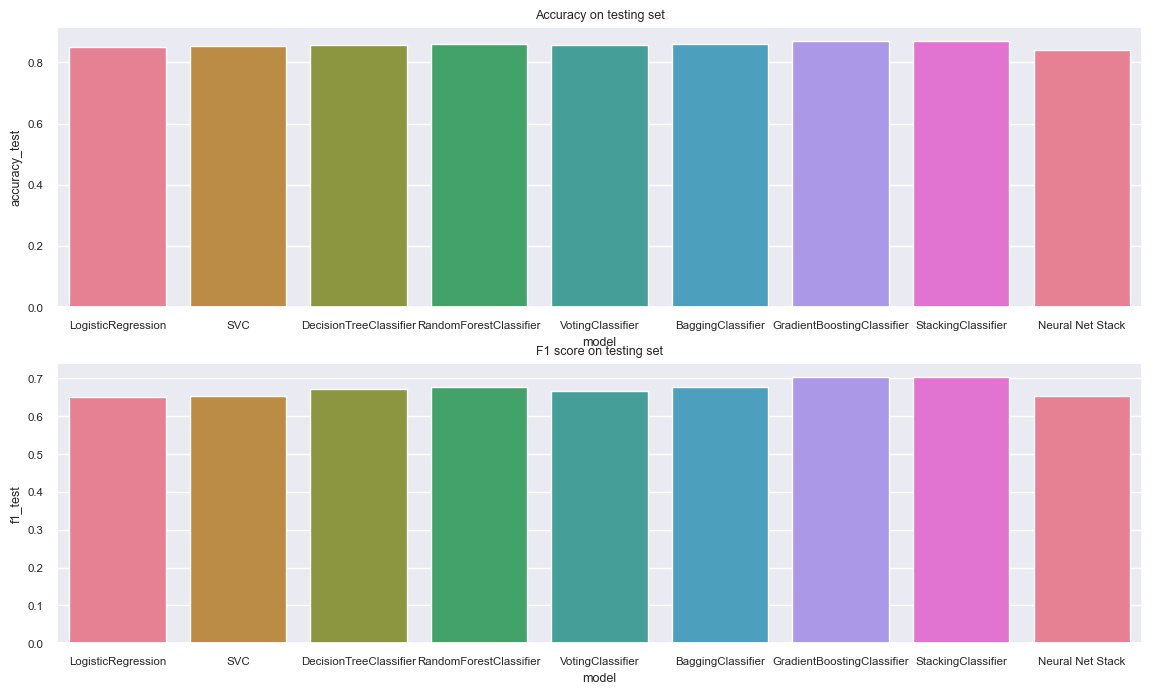

In [103]:
sns.set(font_scale = .75)
fig, ax = plt.subplots(2, figsize=(14,8))

plot1=sns.barplot( data=clf_scores_3, x='model', y='accuracy_test', ax=ax[0], palette=sns.color_palette('husl',8))
plot1.set_title('Accuracy on testing set')

plot1=sns.barplot( data=clf_scores_3, x='model', y='f1_test', ax=ax[1], palette=sns.color_palette('husl',8))
plot1.set_title('F1 score on testing set')

It's clear that the Stacking and Gradient Boosting Classifier did the best, and despite the fact that the Neural network did a phenomenal job on the training set, the high dropout rate was not enough to regularize it successfuly. 

## 7.0 Conclusion

In this project, we saw what factors most likely contribute to someone having a higher paying job. We learned that (given the opportunity) it is good to be married, go to school for a longer period of time, etc. 

We also witnessed how different methods of feature selection can reach different conclusions as to how important various features actually are for making the prediction. The random forest method, for example, determined that some features that have almost no correlation to the outcome, are in fact very important to it in making a prediction (such as 'fnlweight'), but would have almost no bearing when using LogisticRegression.

Lastly, we determined that ensemble learning can let you achieve the next level of performance, but that not all ensemble methods are equal. We also witnessed the potential of the simple neural networks, and how they can achieve a further boost in accuracy; but sometimes at a cost to variance.